<a href="https://colab.research.google.com/github/Sibgat-Ul/Road_Accidents_Pakistan_Prediction/blob/main/toonsquad_445_7_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Group_Name: ToonSquad
    - Imroz Rahim - 2011129
    - Iffaat Ara Mehnaz - 2031340
    - Sibgat Ul Islam - 2111920

### Import the libraries

In [1]:
import pandas as pd
import numpy as np
from openpyxl.styles.builtins import total

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from openpyxl import load_workbook
tqdm.pandas()

import warnings
import nltk

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
nltk.download('punkt_tab')


print(nltk.data.path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the dataset

# rta_dataset = pd.read_excel('./data/RTA Data 2020 to July 2023.xlsx')

rta_dataset = pd.read_excel('/content/drive/MyDrive/CSE445/RTA Data 2020 to July 2023.xlsx')

#### Few helper functions:

In [5]:
from collections import Counter
from nltk.corpus import stopwords

def get_cat_cols(df: pd.DataFrame) -> list:
    """"
    :param df: Dataframe
    :return: list of column names

    to get categorical columns
    """
    return [col for col in df.columns if df[col].dtype == 'object']

def get_num_cols(df):
    """"
    :param df: Dataframe
    :return: list of column names

    to get num columns
    """
    return [col for col in df.columns if df[col].dtype != 'object']

def get_info(dataset: pd.DataFrame):
    """

    :param dataset: pd.DataFrame
    :return: pd.DataFrame

    Makes a new df with missing and unique values.
    """
    new_df = pd.DataFrame()
    new_df['missing_count'] = dataset.isnull().sum()
    new_df['total'] = dataset.shape[0]
    new_df['missing%'] = (dataset.isnull().sum() / dataset.shape[0])*100
    new_df['n_unique'] = dataset.nunique()
    new_df['type'] = dataset.dtypes
    print(f"Size: {rta_dataset.shape}")
    return new_df

def plot_by_status(col_to_plot, to_encode_dict):
    freq_counter = [
        {
            status:
              Counter(
                  rta_dataset[rta_dataset['PatientStatus'] == status][col_to_plot].values
                  )
              } for status in to_encode_dict[4]['PatientStatus']
    ]

    d_list = freq_counter[2]['Dead'].most_common()[:20]
    u_list = freq_counter[0]['Alive & unstable'].most_common()[:20]
    s_list = freq_counter[1]['Alive & stable'].most_common()[:20]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
    plt.subplots_adjust(hspace=.5)
    rotate = 90

    plot1 = sns.barplot(x=[x[0] for x in d_list], y=[x[1] for x in d_list], ax=axes[0])
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=rotate)
    plot1.set_title('Dead')

    plot2 = sns.barplot(x=[x[0] for x in u_list], y=[x[1] for x in u_list], ax=axes[1])
    plot2.set_xticklabels(plot2.get_xticklabels(), rotation=rotate)
    plot2.set_title('Unstable')

    plot3 = sns.barplot(x=[x[0] for x in s_list], y=[x[1] for x in s_list], ax=axes[2])
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=rotate)
    plot3.set_title('Stable')

In [6]:
cat_cols = get_cat_cols(rta_dataset)
num_cols = get_num_cols(rta_dataset)

### Some info of the dataset

In [7]:
info_df = get_info(rta_dataset)
info_df

Size: (46189, 29)


,missing_count,total,missing%,n_unique,type
EcYear,0,46189,0.000000,5,object
EcNumber,7211,46189,15.611942,34800,object
CallTime,5956,46189,12.894845,40170,datetime64[ns]
EmergencyArea,1,46189,0.002165,37520,object
TotalPatientsInEmergency,0,46189,0.000000,13,object
Gender,1,46189,0.002165,4,object
Age,1,46189,0.002165,100,float64
HospitalName,21950,46189,47.522137,162,object
Reason,1,46189,0.002165,23940,object
responsetime,5,46189,0.010825,68,float64



#### Checking the unique values

In [8]:
target_column = 'PatientStatus'

filtered_cols = rta_dataset[info_df[info_df['n_unique'] < 15].index]
unique_values = [{f'{col}: {rta_dataset[col].unique()}'} for col in filtered_cols.columns]
unique_values

[{"EcYear: [2020 2021 2022 'Hospital' 2023]"},
 {"TotalPatientsInEmergency: [1 2 3 4 8 6 5 10 7 11 9 'Alive & unstable' 15]"},
 {"Gender: ['Male' 'Female' 'Other' nan 0]"},
 {"EducationTitle: ['Intermediate' 'Illetrate' 'Matric' 'Primary' 'Graduation' 'Masters'\n 'Middle' 'PHD' nan 0]"},
 {"InjuryType: ['Minor' 'Single Fracture' 'Head Injury' 'Multiple Fractures'\n 'Spinal Injury' nan]"},
 {"Cause: ['Over Speed' 'Carelessness' 'Tyre Burst' 'U Turn' 'Others' 'Wrong Turn'\n 'One Wheeling' nan]"},
 {"PatientStatus: ['Alive & unstable' 'Alive & stable' 'Dead' nan]"},
 {'BicycleInvovled: [ 0.  1.  2. nan]'},
 {'BikesInvolved: [ 1.  0.  2.  3. 10. nan]'},
 {'BusesInvolved: [ 0.  1.  2. nan]'},
 {'CarsInvolved: [ 0.  1.  2.  3.  4. nan  5.]'},
 {'CartInvovled: [ 0.  1. nan]'},
 {'RickshawsInvolved: [ 0.  1.  2. nan]'},
 {'TractorInvovled: [ 0.  1. nan]'},
 {'TrainsInvovled: [ 0.  1. nan]'},
 {'TrucksInvolved: [ 0.  1.  2.  3. nan]'},
 {'VansInvolved: [ 0.  1.  2.  4.  3. nan]'},
 {'OthersInvo

### Missing value processing
- We will drop the columns with the most missing values
- drop the rows having problematic values (EcYear with Hospital, 0 for Gender)

We have considered dropping rather than filling the values because there are enough samples available.

In [11]:
def drop_garbage_rows(df, col, to_drop):
    df.drop(index=df[df[col] == to_drop].index, axis=0, inplace=True)

drop_garbage_rows(rta_dataset, "EcYear", "Hospital")
drop_garbage_rows(rta_dataset, "Gender", 0)
drop_garbage_rows(rta_dataset, "TotalPatientsInEmergency", 'Alive & unstable')
drop_garbage_rows(rta_dataset, "EducationTitle", 0)

In [10]:
rta_dataset.drop(columns=['HospitalName', 'EcNumber'], axis="columns", inplace=True)

In [12]:
get_info(rta_dataset)

Size: (46188, 27)


,missing_count,total,missing%,n_unique,type
EcYear,0,46188,0.000000,4,object
CallTime,5956,46188,12.895124,40169,datetime64[ns]
EmergencyArea,1,46188,0.002165,37519,object
TotalPatientsInEmergency,0,46188,0.000000,12,object
Gender,1,46188,0.002165,3,object
Age,1,46188,0.002165,100,float64
Reason,1,46188,0.002165,23939,object
responsetime,5,46188,0.010825,68,float64
EducationTitle,1,46188,0.002165,8,object
InjuryType,1,46188,0.002165,5,object


#### We will drop the values where the patient status is not Dead, because we have low samples of DEAD

In [13]:
to_drop = rta_dataset[(rta_dataset['CallTime'].isnull()) & (rta_dataset["PatientStatus"]!="Dead")]
to_drop.shape

(5825, 27)

In [14]:
rta_dataset.drop(index=to_drop.index, inplace=True)

#### More problematic rows

In [15]:
rta_dataset[rta_dataset["PatientStatus"].isnull()]

,EcYear,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,...,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallYear,CallMonth,Season,CallDay
31355,2022,2022-06-18 13:23:00,"Near 502 Park, Adyala Road Rawalpindi.",2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,6.0,Summer,18.0


In [16]:
rta_dataset[rta_dataset["InjuryType"].isnull()]

,EcYear,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,...,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallYear,CallMonth,Season,CallDay
31355,2022,2022-06-18 13:23:00,"Near 502 Park, Adyala Road Rawalpindi.",2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,6.0,Summer,18.0


In [17]:
# Another problematic row
rta_dataset[rta_dataset["Gender"].isnull()]

,EcYear,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,...,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallYear,CallMonth,Season,CallDay
31355,2022,2022-06-18 13:23:00,"Near 502 Park, Adyala Road Rawalpindi.",2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022.0,6.0,Summer,18.0


In [18]:
rta_dataset.shape

(40363, 27)

In [19]:
rta_dataset.drop(index=rta_dataset[rta_dataset["Gender"].isnull()].index, inplace=True)
rta_dataset.drop(index=rta_dataset[rta_dataset["InjuryType"].isnull()].index, inplace=True)
rta_dataset.shape

(40362, 27)

In [20]:
get_info(rta_dataset)

Size: (40362, 27)


,missing_count,total,missing%,n_unique,type
EcYear,0,40362,0.000000,4,object
CallTime,131,40362,0.324563,40168,datetime64[ns]
EmergencyArea,1,40362,0.002478,37242,object
TotalPatientsInEmergency,0,40362,0.000000,12,object
Gender,0,40362,0.000000,3,object
Age,0,40362,0.000000,98,float64
Reason,0,40362,0.000000,22072,object
responsetime,3,40362,0.007433,68,float64
EducationTitle,0,40362,0.000000,8,object
InjuryType,0,40362,0.000000,5,object


In [21]:
rta_dataset[rta_dataset["EmergencyArea"].isnull()][["PatientStatus", "InjuryType"]]

,PatientStatus,InjuryType
41936,Alive & unstable,Minor


In [22]:
rta_dataset.drop(index=rta_dataset[rta_dataset["EmergencyArea"].isnull()].index, inplace=True)

In [23]:
get_info(rta_dataset)

Size: (40361, 27)


,missing_count,total,missing%,n_unique,type
EcYear,0,40361,0.000000,4,object
CallTime,131,40361,0.324571,40167,datetime64[ns]
EmergencyArea,0,40361,0.000000,37242,object
TotalPatientsInEmergency,0,40361,0.000000,12,object
Gender,0,40361,0.000000,3,object
Age,0,40361,0.000000,98,float64
Reason,0,40361,0.000000,22071,object
responsetime,3,40361,0.007433,68,float64
EducationTitle,0,40361,0.000000,8,object
InjuryType,0,40361,0.000000,5,object


### Working with the CallTime and imputing the missing values for the column which has samples for "Dead"

In [24]:
rta_dataset['CallTime'] = pd.DatetimeIndex(rta_dataset['CallTime'])
rta_dataset['CallHour'] = rta_dataset['CallTime'].dt.hour
rta_dataset['CallDayOfWeek'] = rta_dataset['CallTime'].dt.dayofweek
rta_dataset['CallMonth'] = rta_dataset['CallTime'].dt.month
rta_dataset['CallYear'] = rta_dataset['CallTime'].dt.year
rta_dataset.drop(columns=['CallTime', 'CallYear', 'EcYear'], inplace=True)

cat_cols = get_cat_cols(rta_dataset)
num_cols = get_num_cols(rta_dataset)

In [25]:
from sklearn.impute import KNNImputer
to_impute = ["CallHour", "CallDayOfWeek", "CallMonth", "responsetime"]

imputer = KNNImputer(n_neighbors=1)
rta_dataset[to_impute] = imputer.fit_transform(rta_dataset[to_impute])

In [26]:
get_info(rta_dataset)

Size: (40361, 26)


,missing_count,total,missing%,n_unique,type
EmergencyArea,0,40361,0.000000,37242,object
TotalPatientsInEmergency,0,40361,0.000000,12,object
Gender,0,40361,0.000000,3,object
Age,0,40361,0.000000,98,float64
Reason,0,40361,0.000000,22071,object
responsetime,0,40361,0.000000,68,float64
EducationTitle,0,40361,0.000000,8,object
InjuryType,0,40361,0.000000,5,object
Cause,0,40361,0.000000,7,object
PatientStatus,0,40361,0.000000,3,object


### Plotting

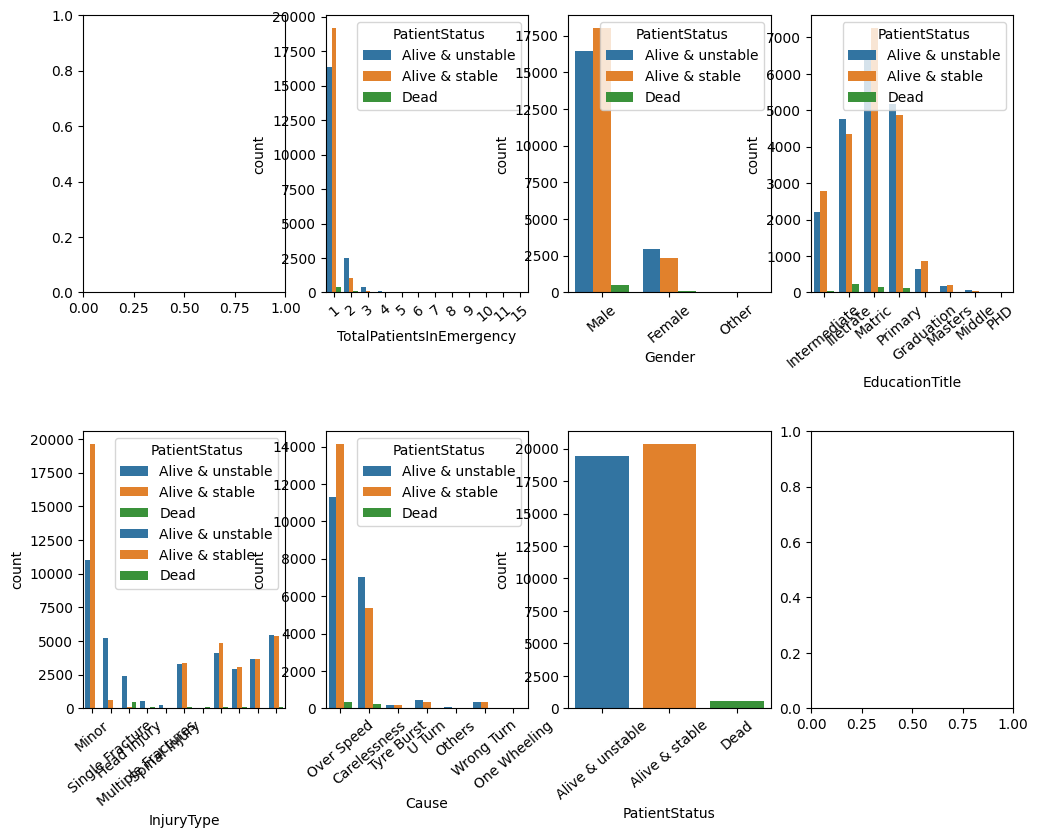

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 9))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in filtered_cols:
    if col in cat_cols:
        plot = sns.countplot(data=rta_dataset, x=rta_dataset[col], hue='PatientStatus', ax=axes[r, c])
        plot.set_xticklabels(plot.get_xticklabels(), rotation=40)

    if c < 3:
        c = c + 1
    else:
        c = 0
        if r < 1:
            r = r + 1

plt.show()

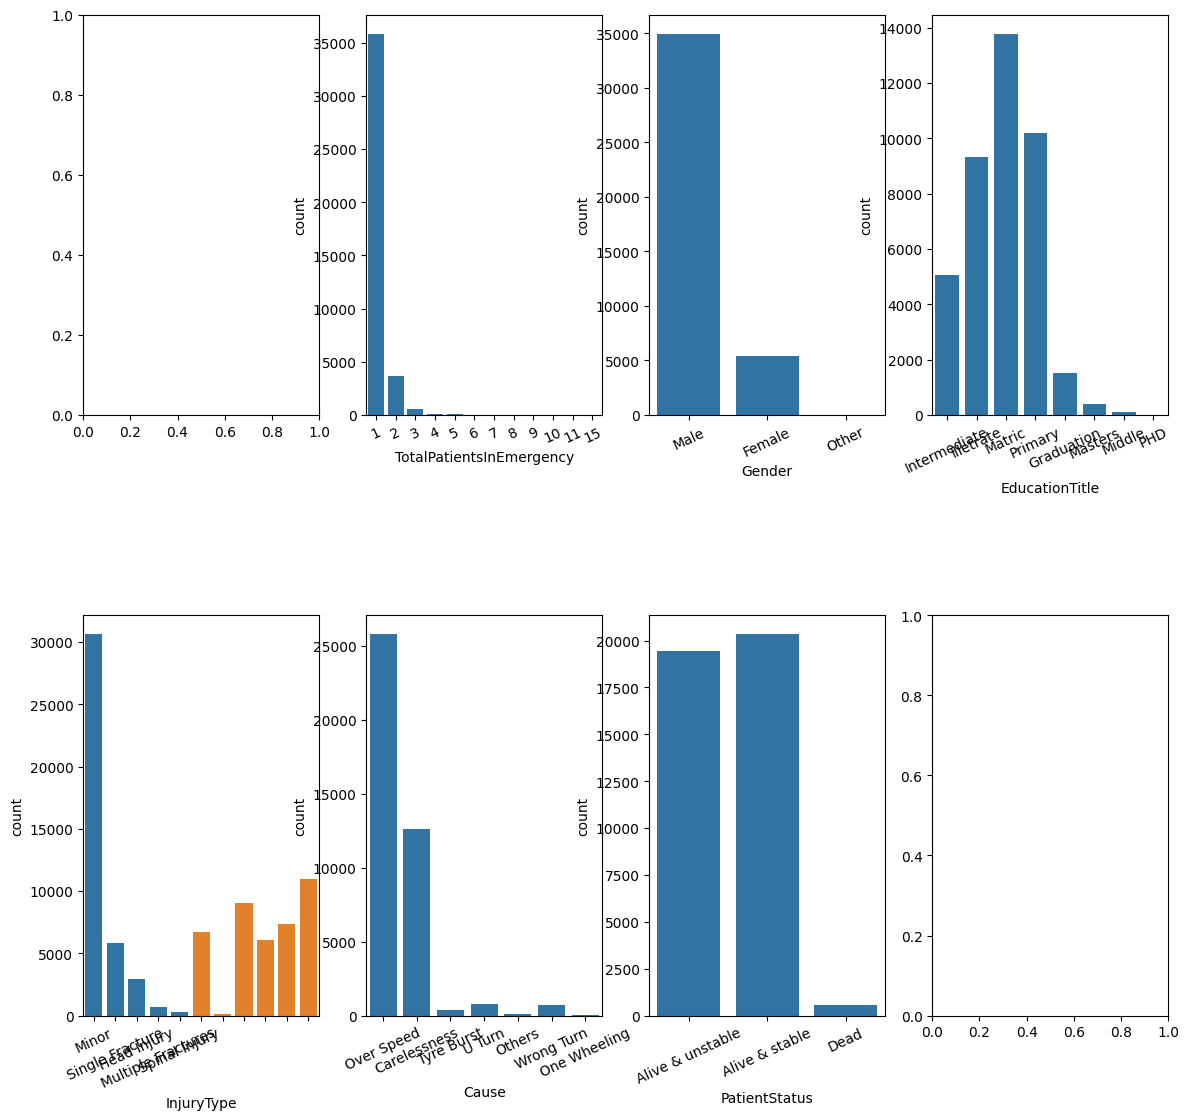

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 13))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in filtered_cols.columns:
    if col in cat_cols:
        plot = sns.countplot(data=rta_dataset, x=rta_dataset[col], ax=axes[r, c])
        plot.set_xticklabels(plot.get_xticklabels(), rotation=25)
    if c < 3:
        c = c + 1
    else:
        c = 0
        if r < 1:
            r = r + 1

plt.show()

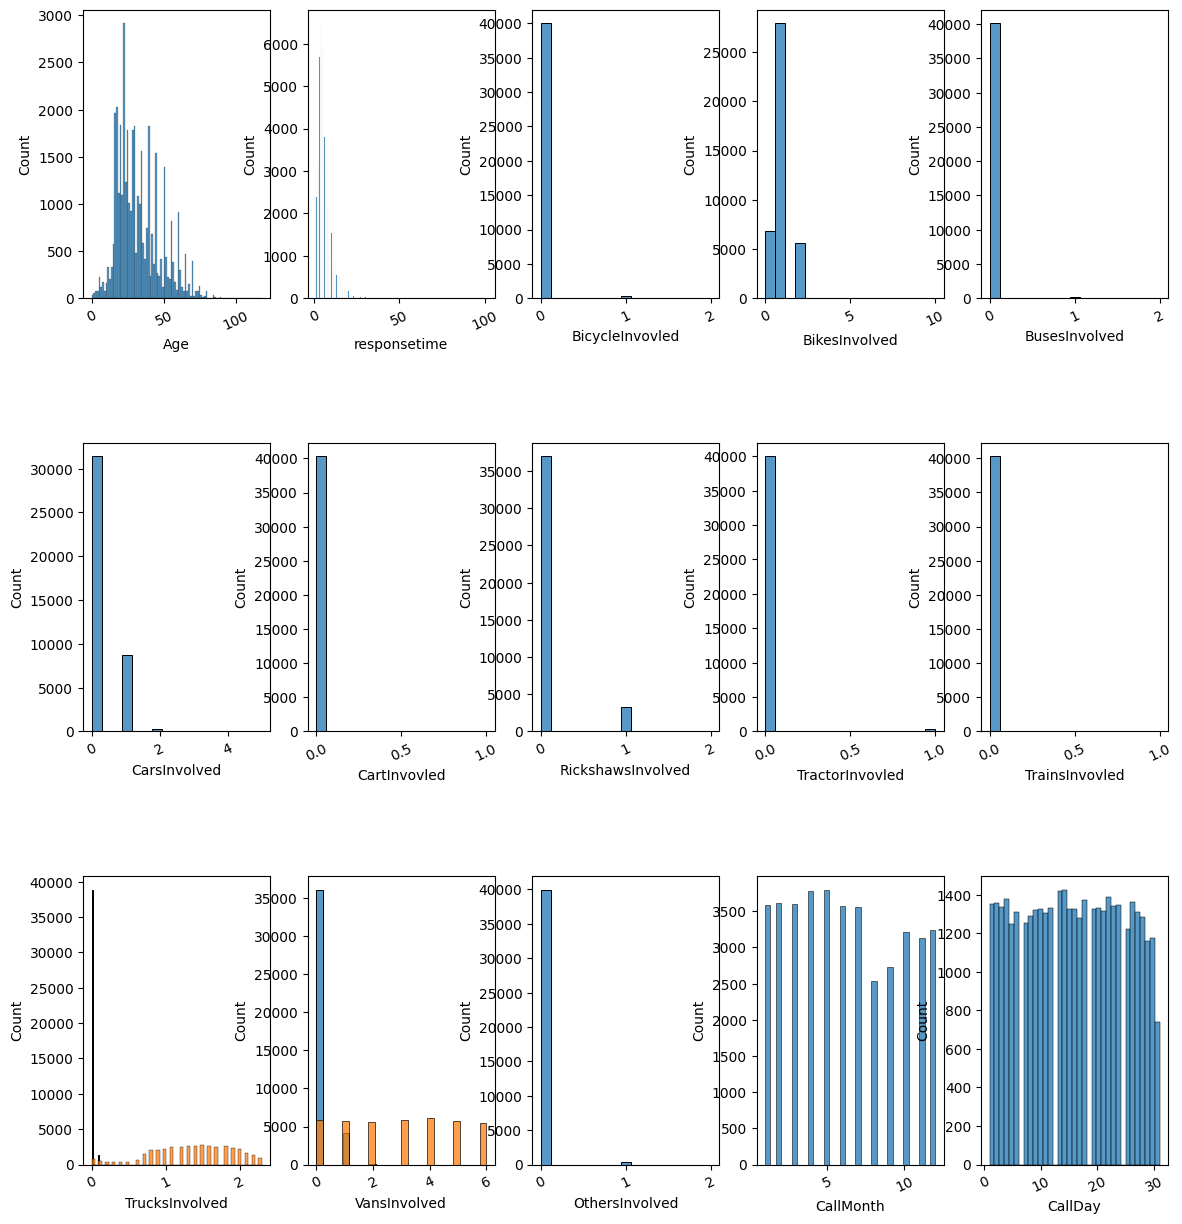

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(14, 15))
plt.subplots_adjust(hspace=.5)

r, c = 0, 0

for col in num_cols:
    plot = sns.histplot(data=rta_dataset, x=col, ax=axes[r, c])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=25)
    if c < 4:
        c = c + 1
    else:
        c = 0
        if r < 2:
            r = r + 1


In [30]:
rta_dataset.columns

Index(['EmergencyArea', 'TotalPatientsInEmergency', 'Gender', 'Age', 'Reason',
       'responsetime', 'EducationTitle', 'InjuryType', 'Cause',
       'PatientStatus', 'BicycleInvovled', 'BikesInvolved', 'BusesInvolved',
       'CarsInvolved', 'CartInvovled', 'RickshawsInvolved', 'TractorInvovled',
       'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved',
       'CallMonth', 'Season', 'CallDay', 'CallHour', 'CallDayOfWeek'],
      dtype='object')

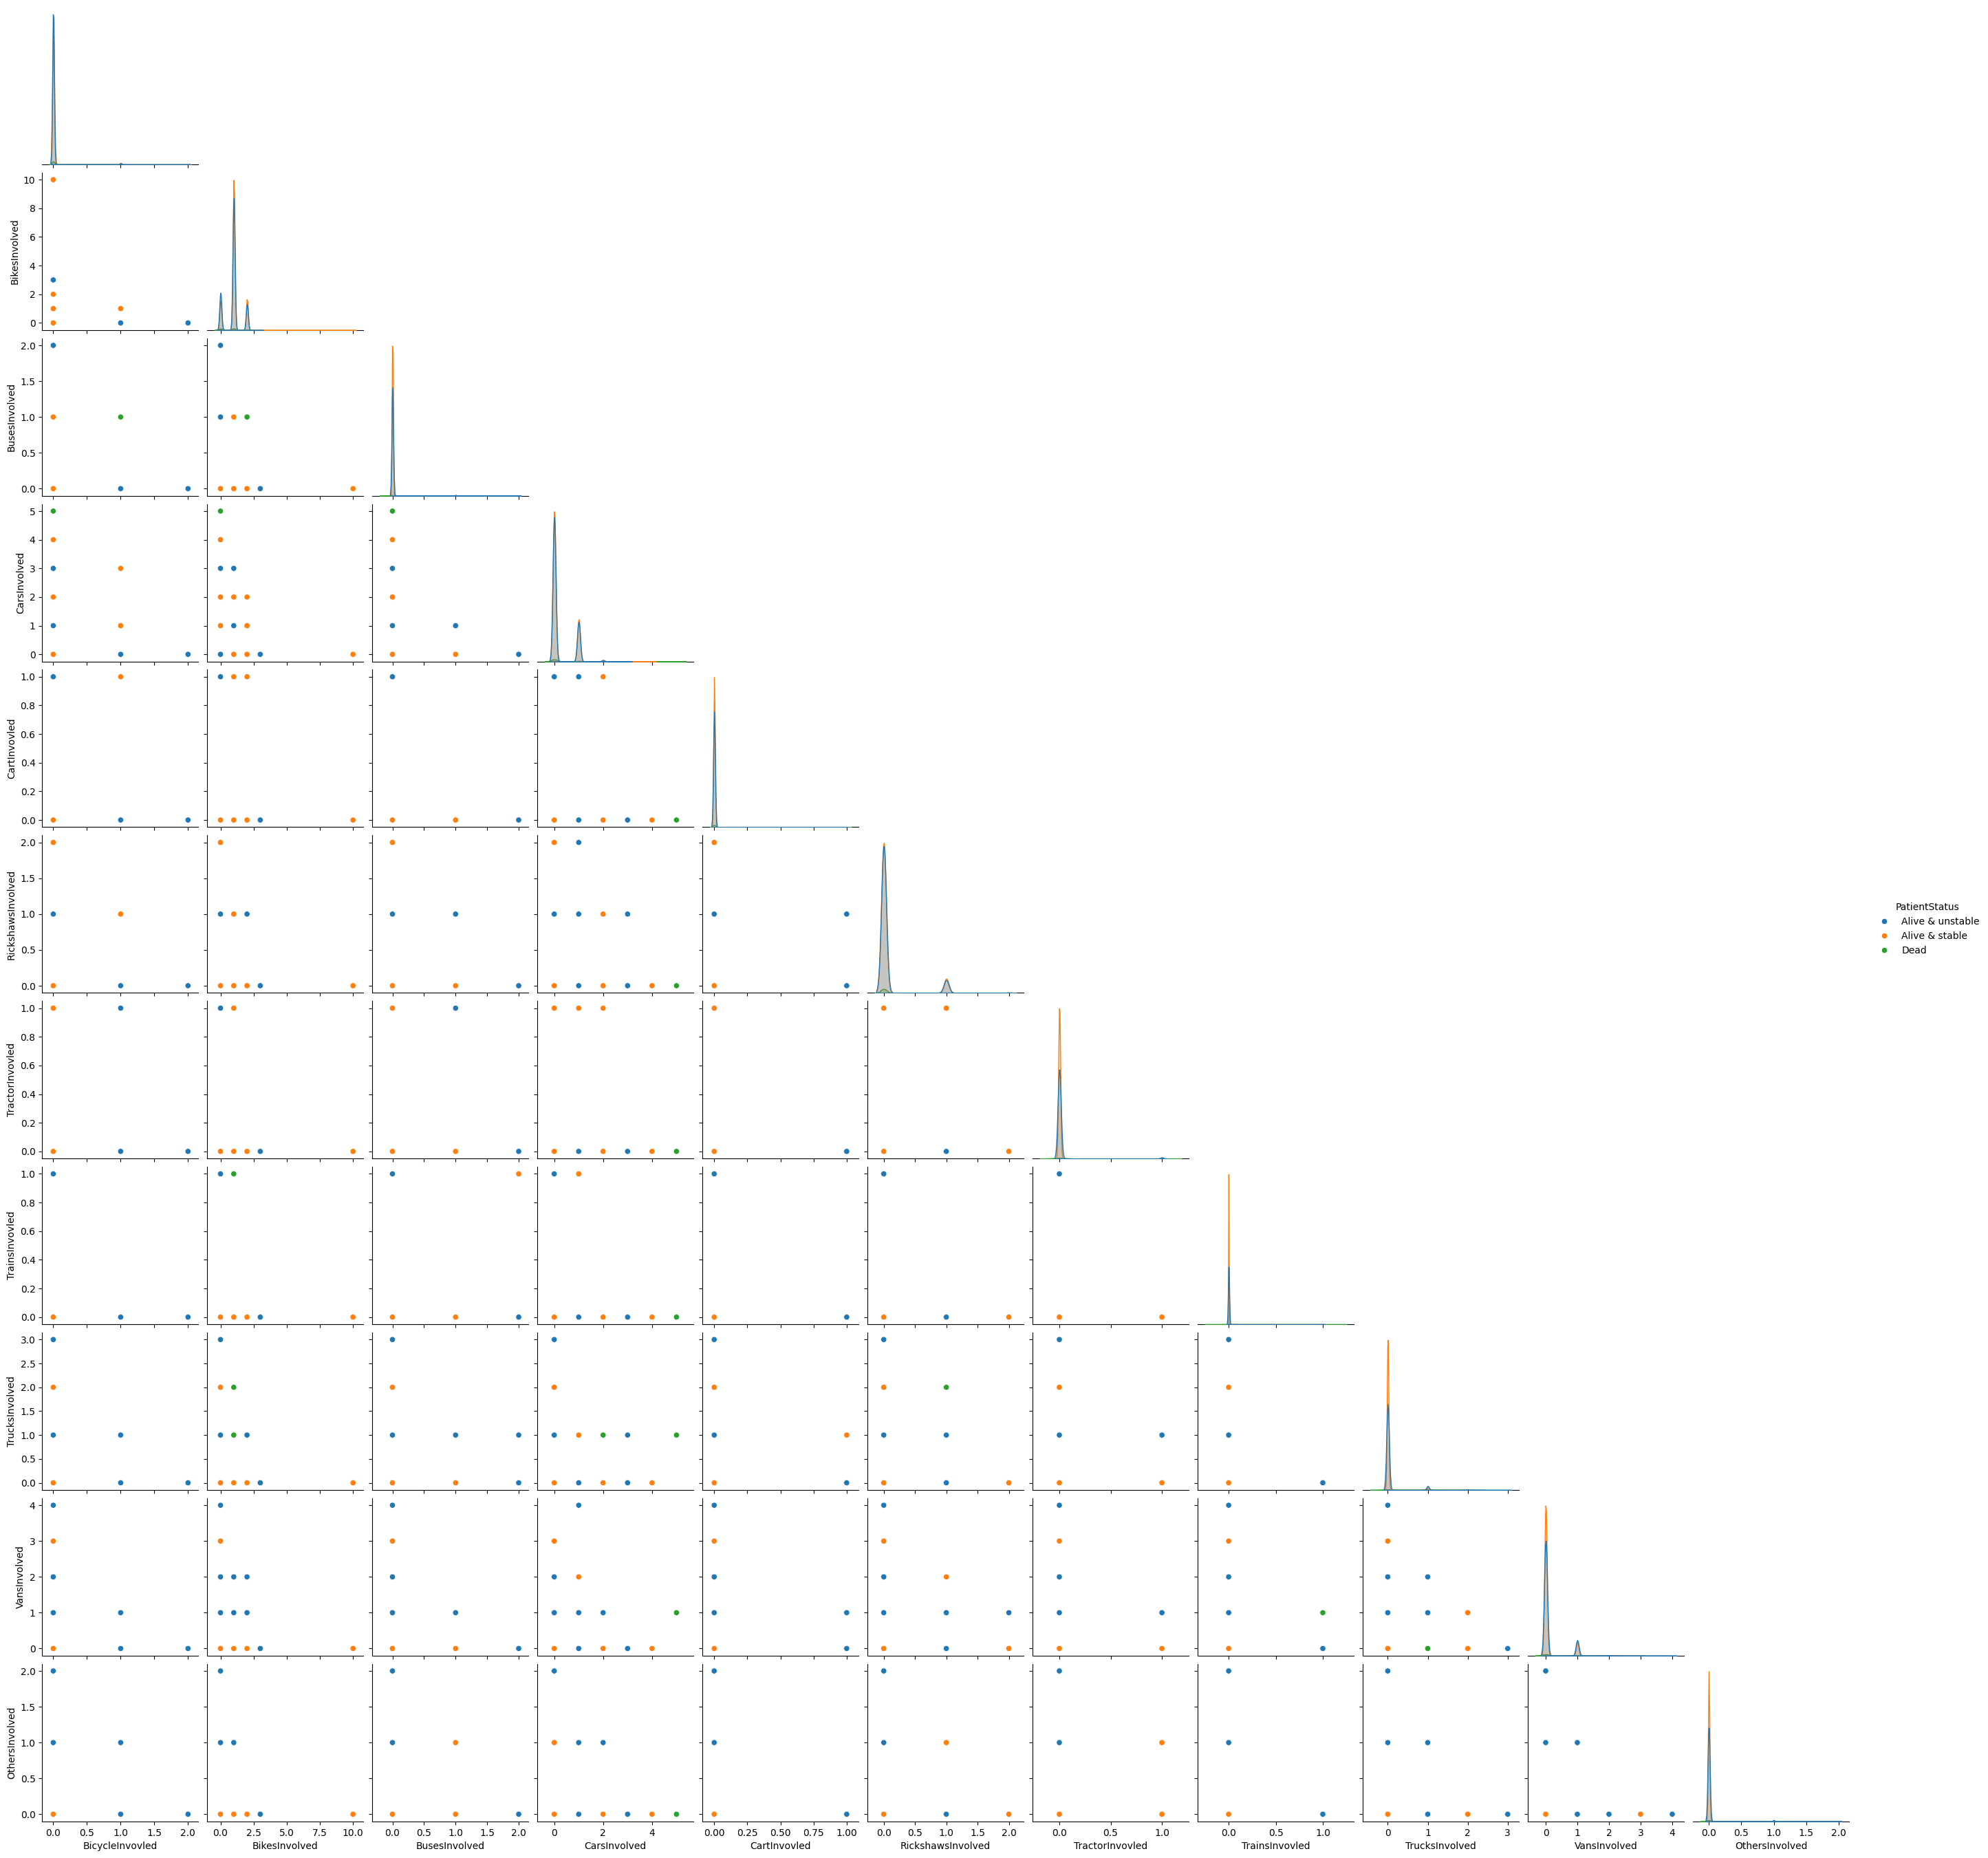

In [31]:
vehicle_wise_cols = ['BicycleInvovled', 'BikesInvolved', 'BusesInvolved',
       'CarsInvolved', 'CartInvovled', 'RickshawsInvolved', 'TractorInvovled',
       'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved', "PatientStatus", "InjuryType"]

sns.pairplot(data=rta_dataset[vehicle_wise_cols], hue="PatientStatus", corner=True)

# plot3 = sns.countplot(data=rta_dataset, x='CallTime', hue='PatientStatus', ax=axes[1,0])
# plot3.set_xticklabels(plot3.get_xticklabels(), rotation=80)

# sns.countplot(data=rta_dataset, x='PatientStatus', hue='Gender', ax=axes[1,1])

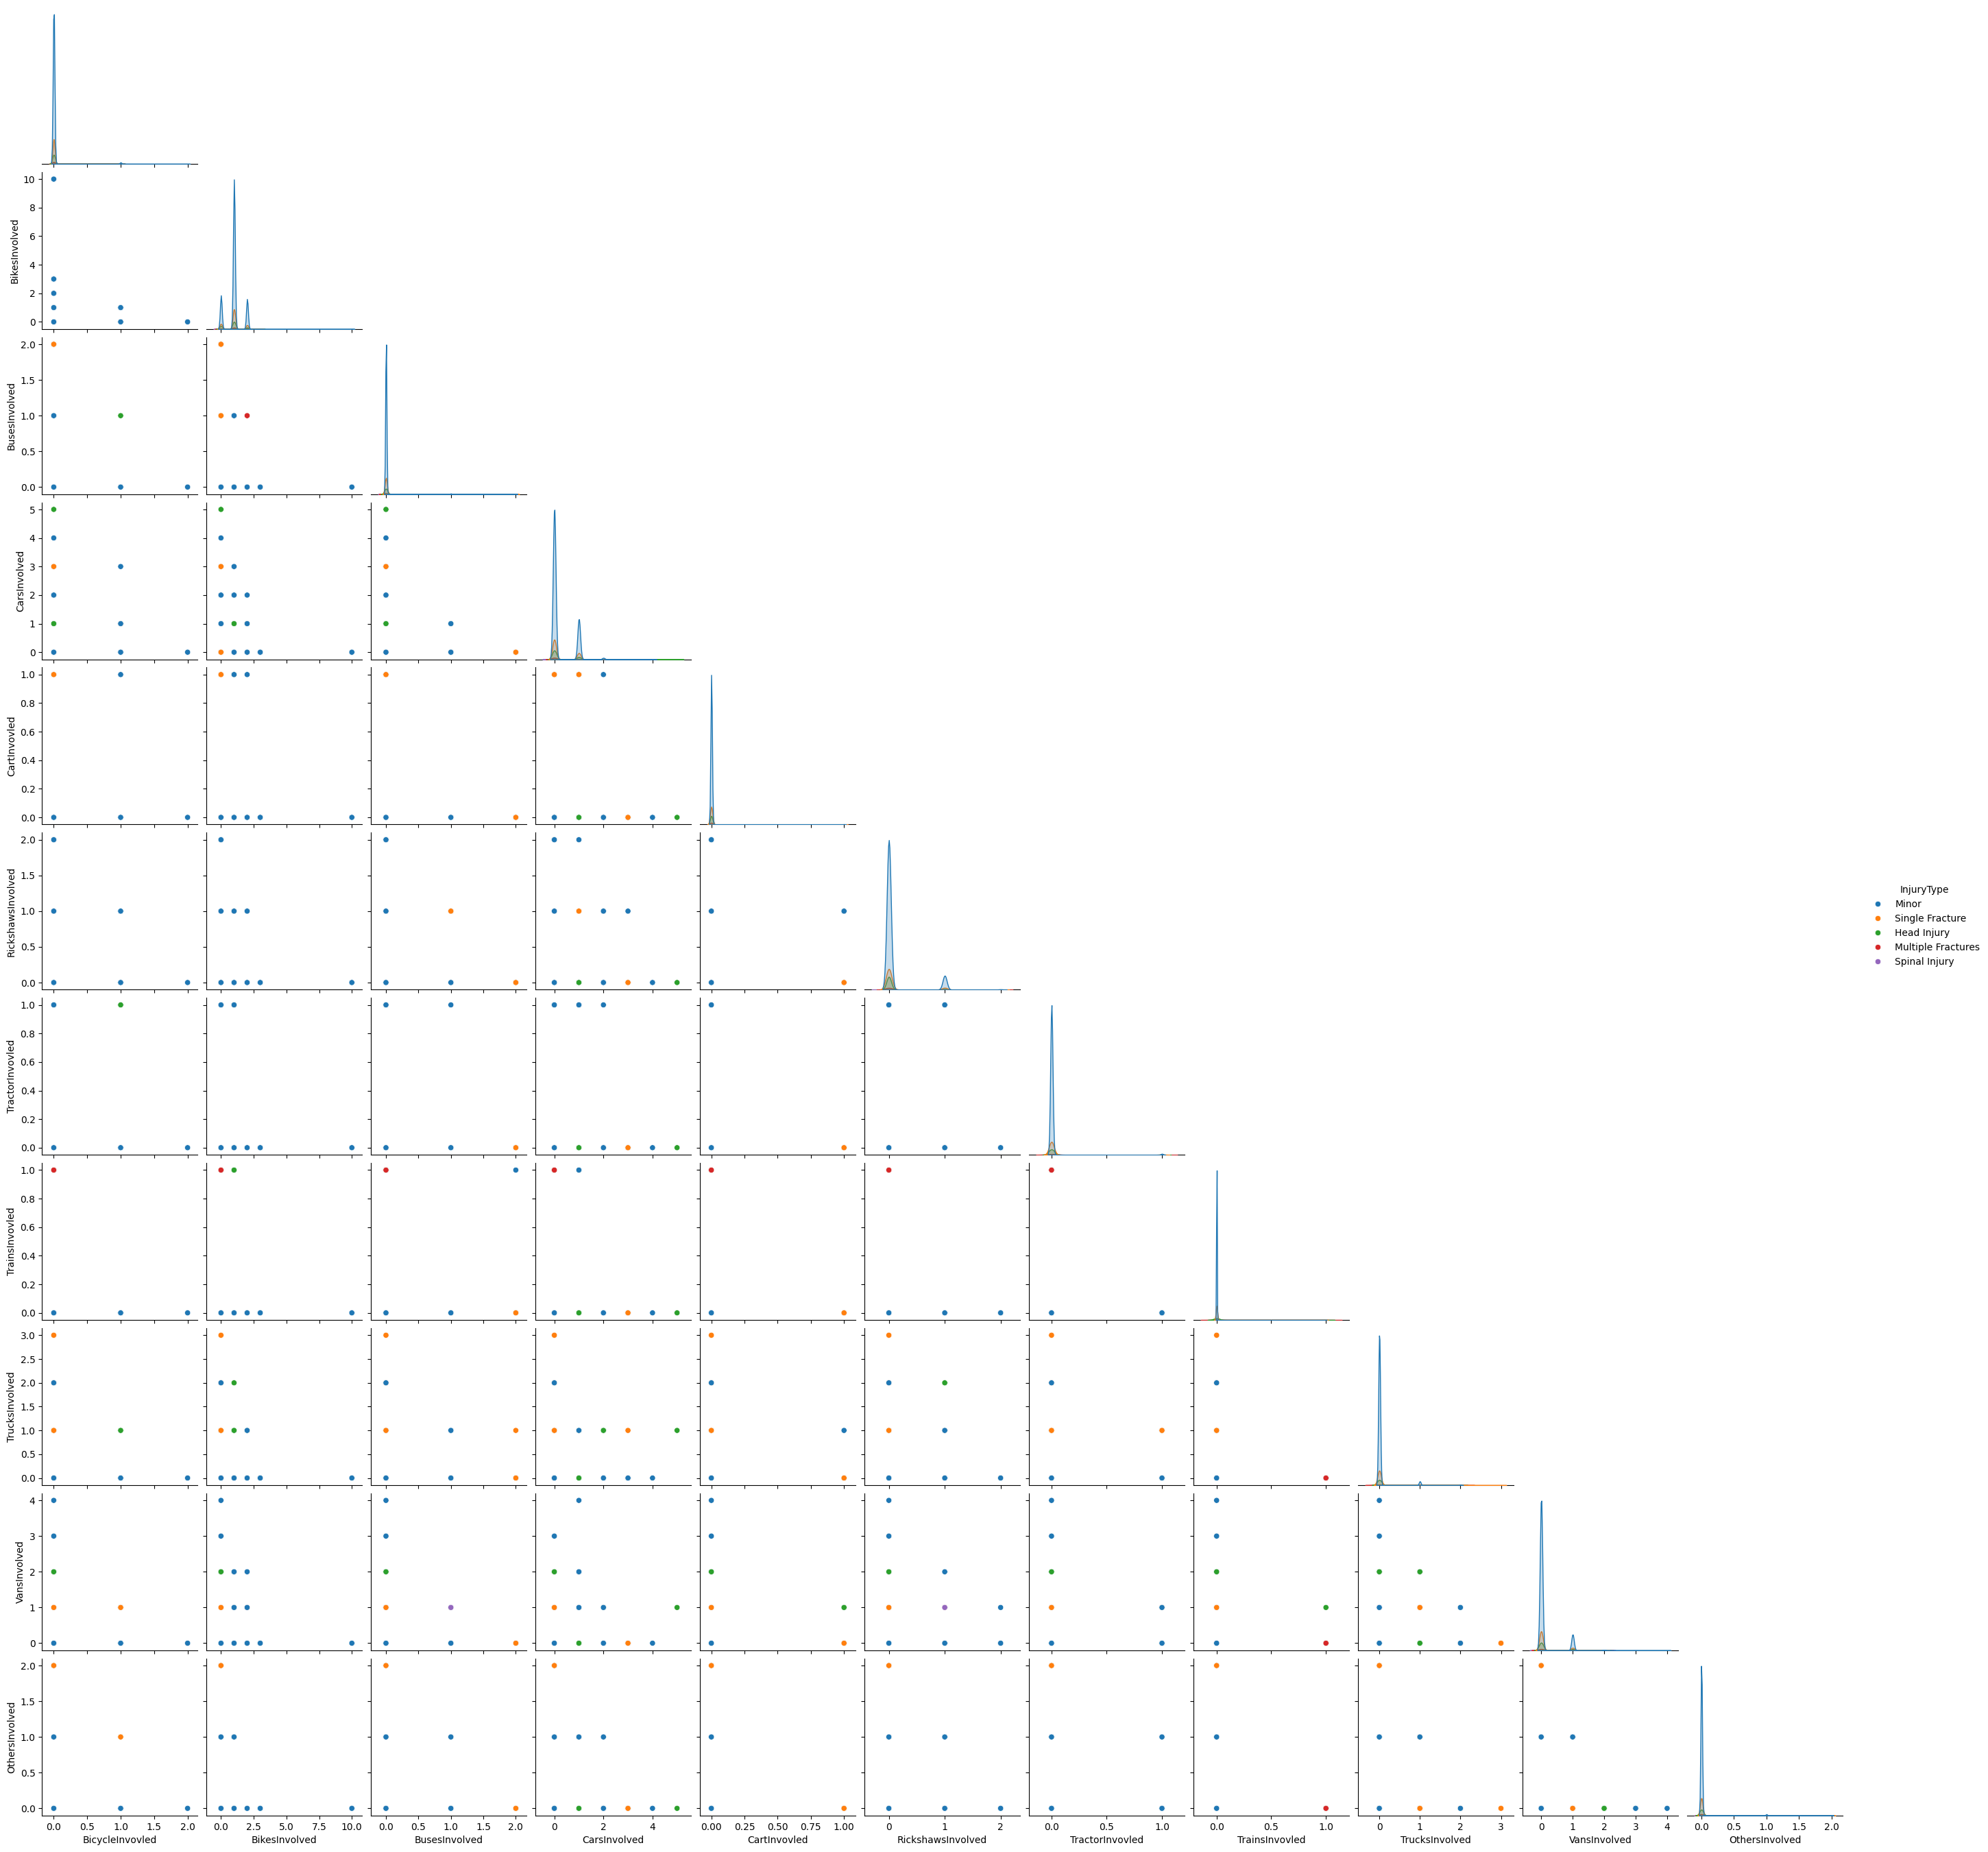

In [ ]:
sns.pairplot(data=rta_dataset[vehicle_wise_cols], hue="InjuryType", corner=True)

<Axes: >

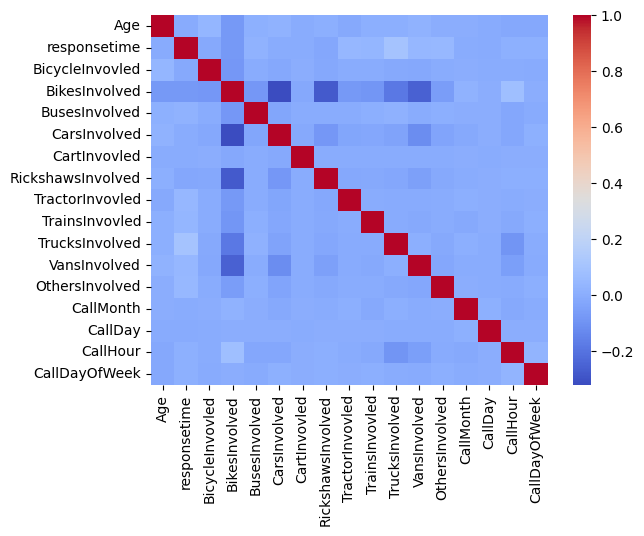

In [ ]:
sns.heatmap(rta_dataset[num_cols].corr(), cmap='coolwarm')

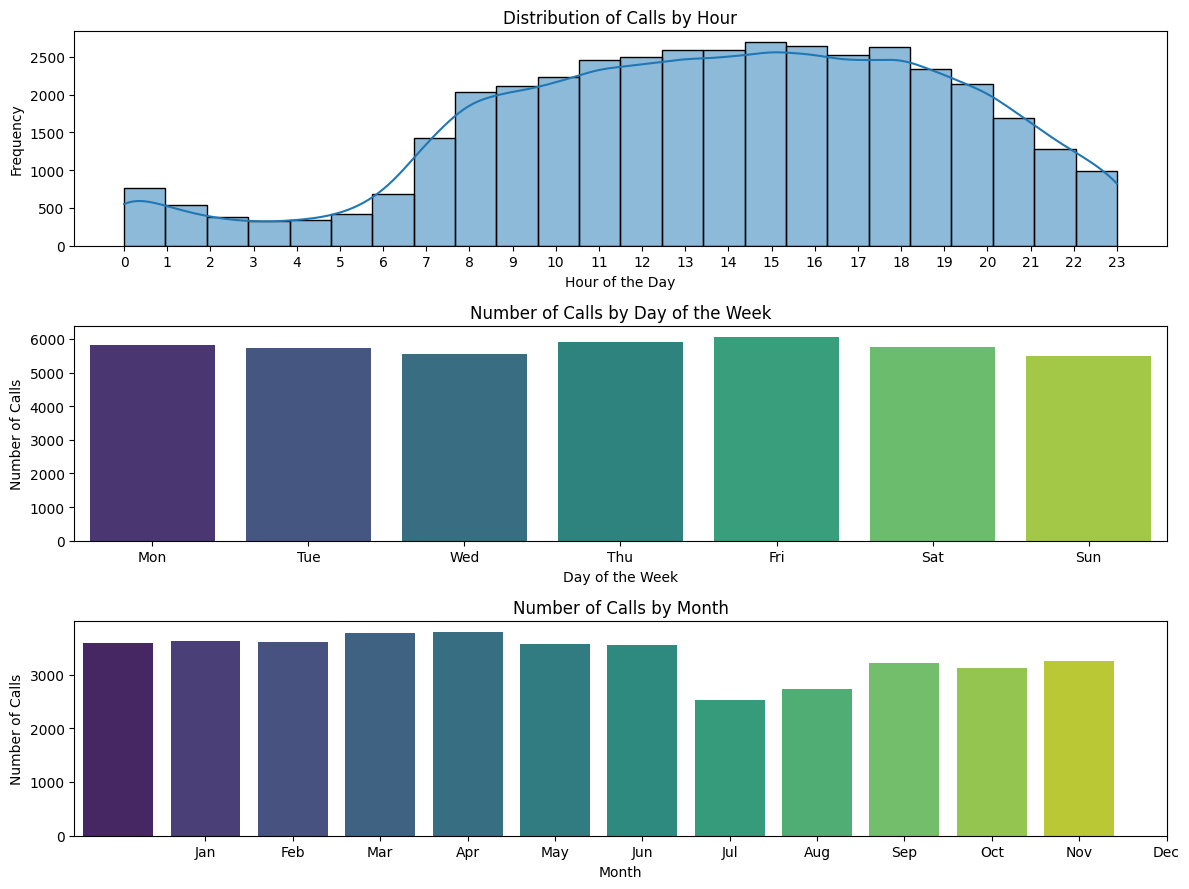

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Plot calls by hour
sns.histplot(rta_dataset['CallHour'], bins=24, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Calls by Hour')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, 24))

# Plot calls by day of the week
sns.countplot(x='CallDayOfWeek', data=rta_dataset, palette='viridis', ax=axes[1])
axes[1].set_title('Number of Calls by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Calls')
axes[1].set_xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plot calls by month
sns.countplot(x='CallMonth', data=rta_dataset, palette='viridis', ax=axes[2])
axes[2].set_title('Number of Calls by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Calls')
axes[2].set_xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def convert_to_shift(x) -> str:
  hour = x
  if hour >= 1 and hour < 6:
    return 'Mid Night'
  elif hour >= 6 and hour < 12:
    return 'Morning'
  elif hour >= 12 and hour < 18:
    return 'Noon'
  elif hour >= 18 and hour < 21:
    return 'Evening'
  else:
    return 'Night'

def conver_to_season(x) -> str:
  month = x
  if month >= 3 and month < 6:
    return 'Spring'
  elif month >= 6 and month <= 9:
    return 'Monsoon'
  elif month >= 10 and month <= 11:
    return 'Autumn'
  else:
    return 'Winter'

rta_dataset['CallHour'] = rta_dataset['CallHour'].apply(convert_to_shift)
rta_dataset['CallMonth'] = rta_dataset['CallMonth'].apply(conver_to_season)

#### Process Reason column with "Same" value

In [ ]:
rta_dataset.reset_index(drop=True, inplace=True)
indexes_of_same = rta_dataset[(rta_dataset['Reason'] == 'Same') | (rta_dataset['Reason'] == 'same')].index
print(indexes_of_same.shape)

for index in indexes_of_same:
    rta_dataset.loc[index, 'Reason'] = rta_dataset.loc[index-1, 'Reason']

print(rta_dataset[(rta_dataset['Reason'] == 'Same') | (rta_dataset['Reason'] == 'same')].shape)

(1578,)
(0, 26)


### Process EmergencyArea

In [ ]:
rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].apply(lambda x : x.lower())

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(rwp|rawalpindi).*",
    value="Rawalpindi",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(gt road|g.t road|g t road).*",
    value="GT Road",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(chowk).*",
    value="Chowk",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(i\.j\.p).*",
    value="IJP Road",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=
    r".*(mandra).*",
    value="Mandra",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(faizabad|faiza bad).*",
    value="Faizabad",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(isb).*",
    value="Isb",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(peshwar).*",
    value="Peshwar",
    regex=True
)

rta_dataset['EmergencyArea'] = rta_dataset['EmergencyArea'].replace(
    to_replace=r".*(sayidan|syedan).*",
    value="Sayidan",
    regex=True
)

In [ ]:
rta_dataset['EmergencyArea'].nunique()

4364

### Looking for the most accident-prone areas

In [ ]:
info_df = get_info(rta_dataset)
filtered_cols = rta_dataset[info_df[info_df['n_unique'] < 10].index]
to_encode = [{col: rta_dataset[col].unique()} for col in filtered_cols.columns if col in cat_cols]

to_encode

Size: (40361, 26)


[{'Gender': array(['Male', 'Female', 'Other'], dtype=object)},
 {'EducationTitle': array(['Intermediate', 'Illetrate', 'Matric', 'Primary', 'Graduation',
         'Masters', 'Middle', 'PHD'], dtype=object)},
 {'InjuryType': array(['Minor', 'Single Fracture', 'Head Injury', 'Multiple Fractures',
         'Spinal Injury'], dtype=object)},
 {'Cause': array(['Over Speed', 'Carelessness', 'Tyre Burst', 'U Turn', 'Others',
         'Wrong Turn', 'One Wheeling'], dtype=object)},
 {'PatientStatus': array(['Alive & unstable', 'Alive & stable', 'Dead'], dtype=object)},
 {'Season': array(['Winter', 'Unknown', 'Fall', 'Rainy', 'Summer', 'Spring'],
        dtype=object)}]

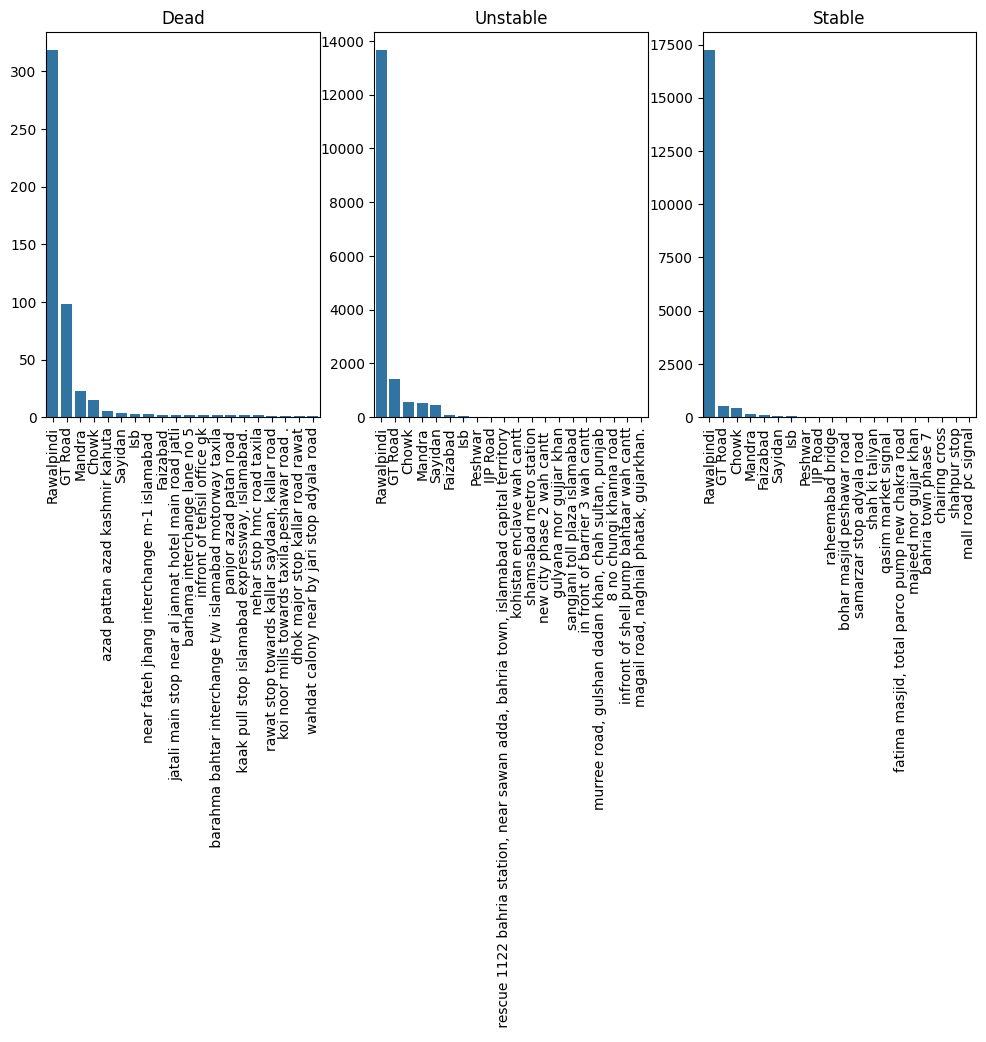

In [ ]:
plot_by_status('EmergencyArea', to_encode_dict=to_encode)

In [ ]:
rta_dataset[rta_dataset.duplicated()]

,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,Cause,PatientStatus,...,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallMonth,Season,CallDay,CallHour,CallDayOfWeek
21095,azad pattan azad kashmir kahuta,5,Male,40.0,Bike slipped saving other vehilce,53.0,Illetrate,Head Injury,Over Speed,Dead,...,0.0,0.0,0.0,1.0,0.0,Monsoon,Unknown,NaN,Morning,4.0
21096,azad pattan azad kashmir kahuta,5,Male,40.0,Bike slipped saving other vehilce,53.0,Illetrate,Head Injury,Over Speed,Dead,...,0.0,0.0,0.0,1.0,0.0,Monsoon,Unknown,NaN,Morning,4.0
32234,Rawalpindi,1,Male,19.0,Bike hit bike and escaped,4.0,Primary,Minor,Over Speed,Alive & stable,...,0.0,0.0,0.0,0.0,0.0,Winter,Winter,2.0,Noon,6.0


In [ ]:
rta_dataset.drop_duplicates(inplace=True)

In [ ]:
rta_dataset[rta_dataset.duplicated()]

,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,Cause,PatientStatus,...,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallMonth,Season,CallDay,CallHour,CallDayOfWeek


In [ ]:
rta_dataset.describe()

,Age,responsetime,BicycleInvovled,BikesInvolved,BusesInvolved,CarsInvolved,CartInvovled,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallDay,CallDayOfWeek
count,40358.00000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40358.000000,40229.000000,40358.000000
mean,32.77209,6.142079,0.009143,0.970167,0.006517,0.229892,0.001982,0.085807,0.009441,0.002503,0.039720,0.107538,0.009763,15.660469,2.990609
std,15.19399,4.703804,0.095702,0.558629,0.082890,0.439378,0.044479,0.286208,0.096704,0.049964,0.209503,0.319486,0.099327,8.756675,1.987481
min,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,21.00000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,30.00000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,3.000000
75%,42.00000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,5.000000
max,118.00000,101.000000,2.000000,10.000000,2.000000,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,4.000000,2.000000,31.000000,6.000000


### Tokenize reason column

In [ ]:
import nltk
import os
import zipfile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import regex as re

# Define the download directory for NLTK data
nltk_data_dir = '/kaggle/working/nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Force download the required NLTK data and specify the directory
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)

# Extract wordnet.zip manually
with zipfile.ZipFile(os.path.join(nltk_data_dir, 'corpora', 'wordnet.zip'), 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_dir, 'corpora'))

# Initialize WordNet Lemmatizer
wnl = WordNetLemmatizer()

# Example usage, assuming 'Reason' column exists in rta_dataset
rta_dataset['reason_tokenized'] = None

# Process each row in the dataset
for index, row in rta_dataset.iterrows():
    sentence = row['Reason'].lower()
    sentence = re.sub(r'[^a-z]', ' ', sentence)  # Remove all non-alphabet characters

    tokenized_words = word_tokenize(sentence)
    filtered_sentence = [
        wnl.lemmatize(w)
        for w in tokenized_words if w not in stopwords.words('english')
    ]

    # Assign processed values back to the dataset
    rta_dataset.loc[index, 'Reason'] = ','.join(list(set(filtered_sentence)))
    rta_dataset.at[index, 'reason_tokenized'] = filtered_sentence


[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...


#### Looking for the most given reasonings for an accident

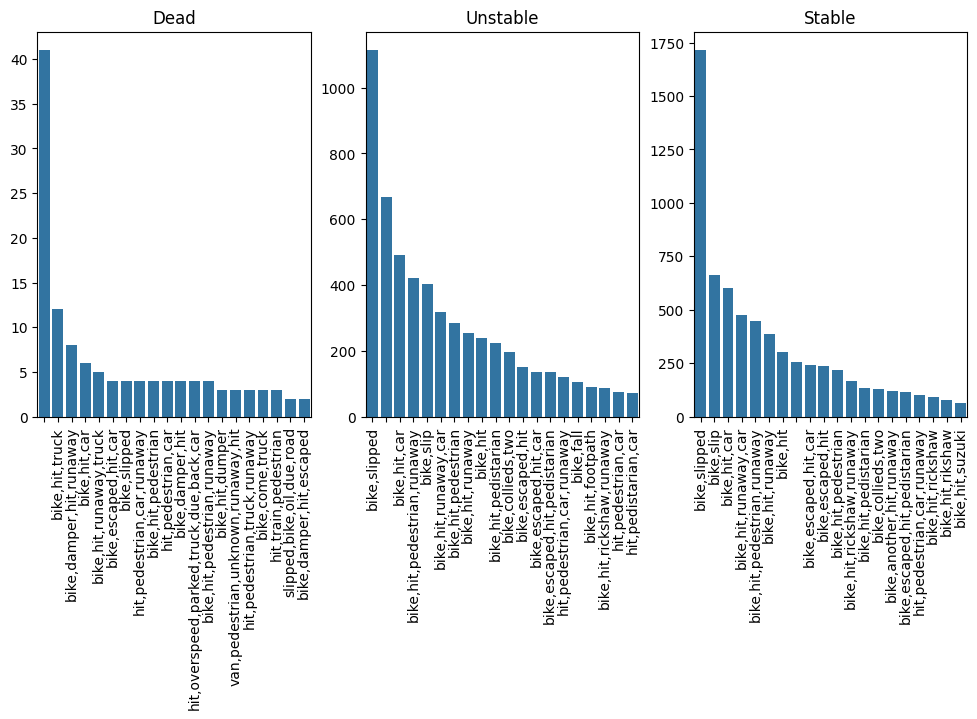

In [ ]:
plot_by_status('Reason', to_encode)

#### Vectorize the Reason column

In [ ]:
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CSE445/w2v_gn_pretrained.bin', binary=True)

In [ ]:
def vectorize(word_list):
  if word_list == None or word_list == []:
    return 0

  vectorized = None

  for word in word_list:
    vectorized = [w2v_model[word] if word in w2v_model else np.zeros(300) for word in word_list]

  vectorized = np.divide(np.sum(vectorized, axis=0), len(vectorized))
  return vectorized

# vectorized = vectorize(['bike', 'hit'])
# print(vectorized)

In [ ]:
rta_dataset["reason_tokenized"] = rta_dataset["reason_tokenized"].progress_apply(vectorize)

100%|██████████| 40358/40358 [00:03<00:00, 11623.35it/s]


In [ ]:
rta_dataset[rta_dataset["reason_tokenized"].str.len() != 300].index

Index([   51,    55,   190,   219,   221,   353,   579,   589,   764,   872,
       ...
       40099, 40121, 40125, 40131, 40138, 40150, 40152, 40154, 40173, 40187],
      dtype='int64', length=966)

In [ ]:
rta_dataset[(rta_dataset["reason_tokenized"].str.len() != 300) & (rta_dataset["PatientStatus"] == "Dead")].shape

(41, 27)

In [ ]:
rta_dataset[(rta_dataset["reason_tokenized"].str.len() != 300) & (rta_dataset["PatientStatus"] == "Dead")]

,EmergencyArea,TotalPatientsInEmergency,Gender,Age,Reason,responsetime,EducationTitle,InjuryType,Cause,PatientStatus,...,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved,CallMonth,Season,CallDay,CallHour,CallDayOfWeek,reason_tokenized
2247,Rawalpindi,2,Male,21.0,,6.0,Masters,Head Injury,Over Speed,Dead,...,0.0,0.0,0.0,0.0,Winter,Unknown,NaN,Evening,3.0,0
2898,Rawalpindi,2,Male,22.0,,1.0,Illetrate,Head Injury,Over Speed,Dead,...,0.0,0.0,1.0,0.0,Monsoon,Fall,16.0,Mid Night,2.0,0
3561,Rawalpindi,3,Male,35.0,,1.0,Illetrate,Head Injury,Tyre Burst,Dead,...,0.0,1.0,0.0,0.0,Monsoon,Rainy,17.0,Night,0.0,0
4234,Rawalpindi,3,Male,20.0,,10.0,Matric,Head Injury,Over Speed,Dead,...,0.0,0.0,0.0,0.0,Monsoon,Rainy,18.0,Evening,5.0,0
8577,Rawalpindi,2,Male,22.0,,6.0,Matric,Head Injury,Over Speed,Dead,...,0.0,0.0,1.0,0.0,Winter,Unknown,NaN,Evening,3.0,0
9192,Sayidan,2,Female,40.0,,8.0,Primary,Head Injury,Carelessness,Dead,...,0.0,1.0,0.0,0.0,Winter,Unknown,NaN,Morning,3.0,0
9762,Mandra,2,Male,34.0,,3.0,Primary,Head Injury,U Turn,Dead,...,0.0,1.0,1.0,0.0,Winter,Spring,7.0,Night,4.0,0
9950,GT Road,5,Male,62.0,,7.0,Illetrate,Head Injury,Over Speed,Dead,...,0.0,0.0,1.0,0.0,Winter,Unknown,NaN,Noon,3.0,0
9982,GT Road,2,Male,30.0,,7.0,Illetrate,Head Injury,U Turn,Dead,...,0.0,2.0,0.0,0.0,Winter,Winter,3.0,Morning,4.0,0
12842,GT Road,3,Male,26.0,,1.0,Illetrate,Multiple Fractures,Over Speed,Dead,...,0.0,1.0,1.0,0.0,Winter,Unknown,NaN,Noon,3.0,0


In [ ]:
rta_dataset.drop(index=rta_dataset[rta_dataset["reason_tokenized"].str.len() != 300].index, inplace=True, axis="row")
rta_dataset.reset_index(inplace=True)

In [ ]:
rta_dataset.columns

Index(['index', 'EmergencyArea', 'TotalPatientsInEmergency', 'Gender', 'Age',
       'Reason', 'responsetime', 'EducationTitle', 'InjuryType', 'Cause',
       'PatientStatus', 'BicycleInvovled', 'BikesInvolved', 'BusesInvolved',
       'CarsInvolved', 'CartInvovled', 'RickshawsInvolved', 'TractorInvovled',
       'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved',
       'CallMonth', 'Season', 'CallDay', 'CallHour', 'CallDayOfWeek',
       'reason_tokenized'],
      dtype='object')

In [ ]:
rta_dataset[[i for i in range(300)]] = pd.DataFrame(rta_dataset.reason_tokenized.to_list())
print(rta_dataset.shape)

(39392, 328)


### Encoding the values

In [ ]:
# label encoder
to_map = {
    'InjuryType':{},
    'Cause':{},
    'EducationTitle':{},
    'PatientStatus':{},
    'CallHour':{},
    'CallMonth':{},
  }

for col in to_map:
    unq = rta_dataset[col].unique()
    to_map[col] = {unq[i]: i for i in range(len(unq))}
    rta_dataset[col] = rta_dataset[col].map(to_map[col])

# Onehot Encoding
rta_dataset = pd.get_dummies(rta_dataset, columns=["Gender"], drop_first=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
rta_dataset["EmergencyArea"] = le.fit_transform(rta_dataset["EmergencyArea"])

In [ ]:
rta_dataset.EmergencyArea.info()

<class 'pandas.core.series.Series'>
RangeIndex: 39392 entries, 0 to 39391
Series name: EmergencyArea
Non-Null Count  Dtype
--------------  -----
39392 non-null  int64
dtypes: int64(1)
memory usage: 307.9 KB


In [ ]:
# sns.countplot(data=rta_dataset, x='responsetime', hue="PatientStatus")

In [ ]:
rta_dataset.drop(columns=["TotalPatientsInEmergency", "Reason", "responsetime", "reason_tokenized"], axis="columns", inplace=True)

In [ ]:
rta_dataset.columns

Index([          'index',   'EmergencyArea',             'Age',
        'EducationTitle',      'InjuryType',           'Cause',
         'PatientStatus', 'BicycleInvovled',   'BikesInvolved',
         'BusesInvolved',
       ...
                     292,               293,               294,
                     295,               296,               297,
                     298,               299,     'Gender_Male',
          'Gender_Other'],
      dtype='object', length=325)

In [ ]:
# sns.pairplot(rta_dataset[['EmergencyArea', 'Gender_Male', 'Gender_Other', 'Age',
#        'EducationTitle', 'InjuryType', 'Cause', 'PatientStatus', 'BicycleInvovled',
#         'BikesInvolved', 'BusesInvolved', 'CarsInvolved', 'CartInvovled',
#                           'RickshawsInvolved', 'TractorInvovled',
#        'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved',
#        'CallHour', 'CallDayOfWeek', 'CallMonth']], corner=True)

In [ ]:
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.model_selection import train_test_split

# X_train, X_test, Y_train, Y_test = train_test_split(
#     rta_dataset.drop(["PatientStatus", "index"], axis="columns"),
#     rta_dataset["PatientStatus"],
#     test_size=0.2,
#     shuffle=True
# )

# lr_cv = LogisticRegressionCV(cv=10, solver="saga", verbose=42, n_jobs=-1)

# X_train.columns = X_train.columns.astype(str)
# X_test.columns = X_test.columns.astype(str)

# lr_cv.fit(X_train, Y_train)

In [ ]:
# from sklearn.metrics import accuracy_score
# preds = lr_cv.predict(X_test)
# print("accuracy: ", accuracy_score(Y_test, preds))

In [ ]:
# import pickle

# with open('lr_445_v0.pkl', 'wb') as f:
#     pickle.dump(lr_cv, f)

In [ ]:
# !mv lr_445_v0.pkl drive/MyDrive/

In [44]:
!pip install optuna scikit-learn -q
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [47]:
def plot_solver_iter(dataset):
    targets=["PatientStatus", "InjuryType"]
    X = dataset.drop(columns=["index"], axis="columns")
    y = rta_dataset[targets]

    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        X,
        y,
        test_size=0.25,
        shuffle=True,
        stratify=y
    )


    X_train_i.columns = X_train_i.columns.astype(str)
    X_test_i.columns = X_test_i.columns.astype(str)

    for target in targets:
        print(f"========{target}=========")
        fig, axes = plt.subplots(2, 1, figsize=(12, 9))

        X_train = X_train_i.drop(columns=[target], axis="columns")
        y_train = y_train_i[target]

        X_test = X_test_i.drop(columns=[target], axis="columns")
        y_test = y_test_i[target]

        print("Features: ", X_train.columns)
        print("Label: ", y_train.name)

        solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
        max_iters = [50, 100, 150, 200, 250, 300]

        solver_scores = []
        for solver in solvers:
            model = LogisticRegression(solver=solver)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            solver_scores.append(accuracy_score(y_test, y_pred))

            results = {
                'accuracy': accuracy_score(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1': f1_score(y_test, y_pred, average='weighted')
            }

            print(f"========{target}: {solver}=========")
            print(f"\nResults for {target}:")
            print(f"Accuracy: {results['accuracy']:.4f}")
            print(f"Precision: {results['precision']:.4f}")
            print(f"Recall: {results['recall']:.4f}")
            print(f"F1 Score: {results['f1']:.4f}")

            print("\nConfusion Matrix:")
            for i in results["confusion_matrix"]:
                print(f"{[i]}\n")

        axes[0].plot(solvers, solver_scores, marker='o')
        axes[0].legend()
        axes[0].set_title(f'Accuracy vs Solver on {target}')
        axes[0].set_xlabel('Solver')
        axes[0].set_ylabel('Accuracy')

        max_iter_scores = []
        for max_iter in max_iters:
            model = LogisticRegression(max_iter=max_iter)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            max_iter_scores.append(accuracy_score(y_test, y_pred))

            results = {
                'accuracy': accuracy_score(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1': f1_score(y_test, y_pred, average='weighted')
            }

            print(f"========{target}: {max_iter}=========")
            print(f"\nResults for {target}:")
            print(f"Accuracy: {results['accuracy']:.4f}")
            print(f"Precision: {results['precision']:.4f}")
            print(f"Recall: {results['recall']:.4f}")
            print(f"F1 Score: {results['f1']:.4f}")

            print("\nConfusion Matrix:")
            for i in results["confusion_matrix"]:
                print(f"{[i]}\n")

        axes[1].plot(max_iters, max_iter_scores, marker='o')
        axes[1].legend()
        axes[1].set_title(f'Accuracy vs Max Iterations on {target}')
        axes[1].set_xlabel('Max Iterations')
        axes[1].set_ylabel('Accuracy')

        plt.show()


========PatientStatus=========
Features:  Index(['EmergencyArea', 'TotalPatientsInEmergency', 'Gender', 'Age', 'Reason',
       'responsetime', 'EducationTitle', 'InjuryType', 'Cause',
       'BicycleInvovled', 'BikesInvolved', 'BusesInvolved', 'CarsInvolved',
       'CartInvovled', 'RickshawsInvolved', 'TractorInvovled',
       'TrainsInvovled', 'TrucksInvolved', 'VansInvolved', 'OthersInvolved',
       'CallMonth', 'Season', 'CallDay', 'CallHour', 'CallDayOfWeek'],
      dtype='object')
Label:  PatientStatus


ValueError: could not convert string to float: 'Mareer Hassan Stop '

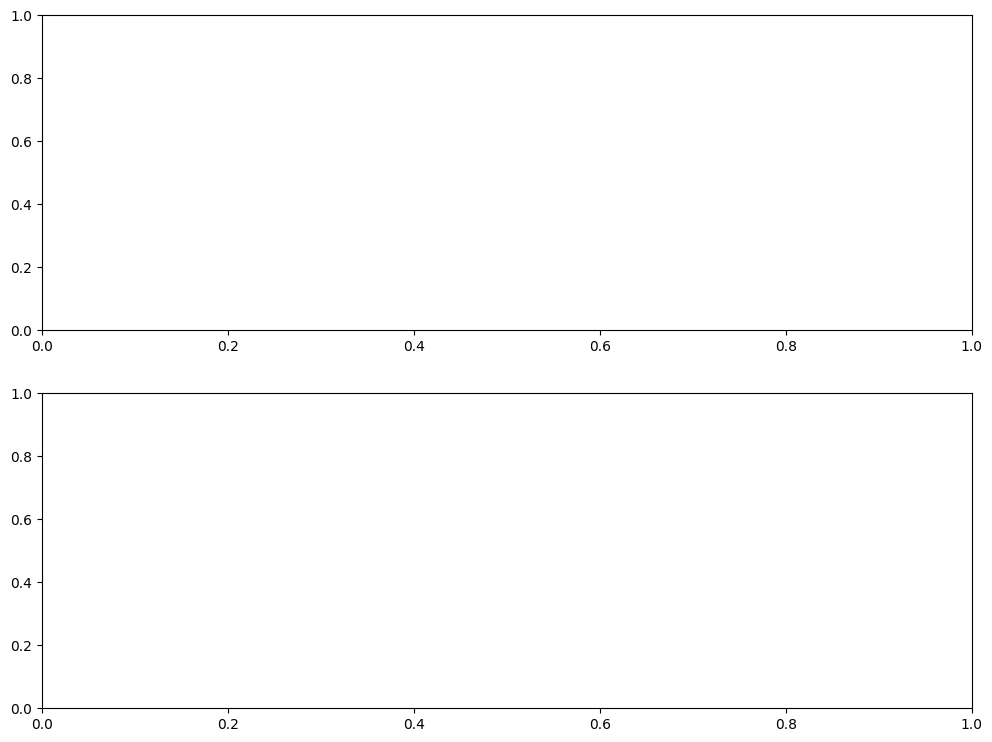

In [48]:
plot_solver_iter(rta_dataset)


In [32]:
!pip install xgboost

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from openpyxl import load_workbook

file_path = '/content/drive/MyDrive/CSE445/RTA Data 2020 to July 2023.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

In [35]:
label_encoders = {}
for column in ['PatientStatus', 'InjuryType']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data = data.select_dtypes(include=[np.number])
data = data.dropna()

X = data.drop(columns=['PatientStatus', 'InjuryType'])
y_status = data['PatientStatus']
y_injury = data['InjuryType']


In [52]:
X_train_status, X_test_status, y_train_status, y_test_status = train_test_split(X, y_status, test_size=0.2, random_state=42)
X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(X, y_injury, test_size=0.2, random_state=42)

In [53]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    precision = precision_score(y_test, predictions, average='weighted')
    return accuracy, f1, recall, precision

dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

metrics_dt_status = evaluate_model(dt_model, X_train_status, X_test_status, y_train_status, y_test_status)
metrics_xgb_status = evaluate_model(xgb_model, X_train_status, X_test_status, y_train_status, y_test_status)

metrics_dt_injury = evaluate_model(dt_model, X_train_injury, X_test_injury, y_train_injury, y_test_injury)
metrics_xgb_injury = evaluate_model(xgb_model, X_train_injury, X_test_injury, y_train_injury, y_test_injury)


In [55]:

metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'XGBoost', 'Decision Tree', 'XGBoost'],
    'Target': ['PatientStatus', 'PatientStatus', 'InjuryType', 'InjuryType'],
    'Accuracy': [metrics_dt_status[0], metrics_xgb_status[0], metrics_dt_injury[0], metrics_xgb_injury[0]],
    'F1 Score': [metrics_dt_status[1], metrics_xgb_status[1], metrics_dt_injury[1], metrics_xgb_injury[1]],
    'Recall': [metrics_dt_status[2], metrics_xgb_status[2], metrics_dt_injury[2], metrics_xgb_injury[2]],
    'Precision': [metrics_dt_status[3], metrics_xgb_status[3], metrics_dt_injury[3], metrics_xgb_injury[3]]
})
print(metrics_df)
metrics_df.to_excel('model_metrics.xlsx', index=False)


           Model         Target  Accuracy  F1 Score    Recall  Precision
0  Decision Tree  PatientStatus  0.518394  0.518019  0.518394   0.517717
1        XGBoost  PatientStatus  0.594705  0.587481  0.594705   0.594006
2  Decision Tree     InjuryType  0.596321  0.603535  0.596321   0.611141
3        XGBoost     InjuryType  0.749938  0.654915  0.749938   0.628439


In [41]:
from google.colab import files
files.download('/content/model_metrics.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

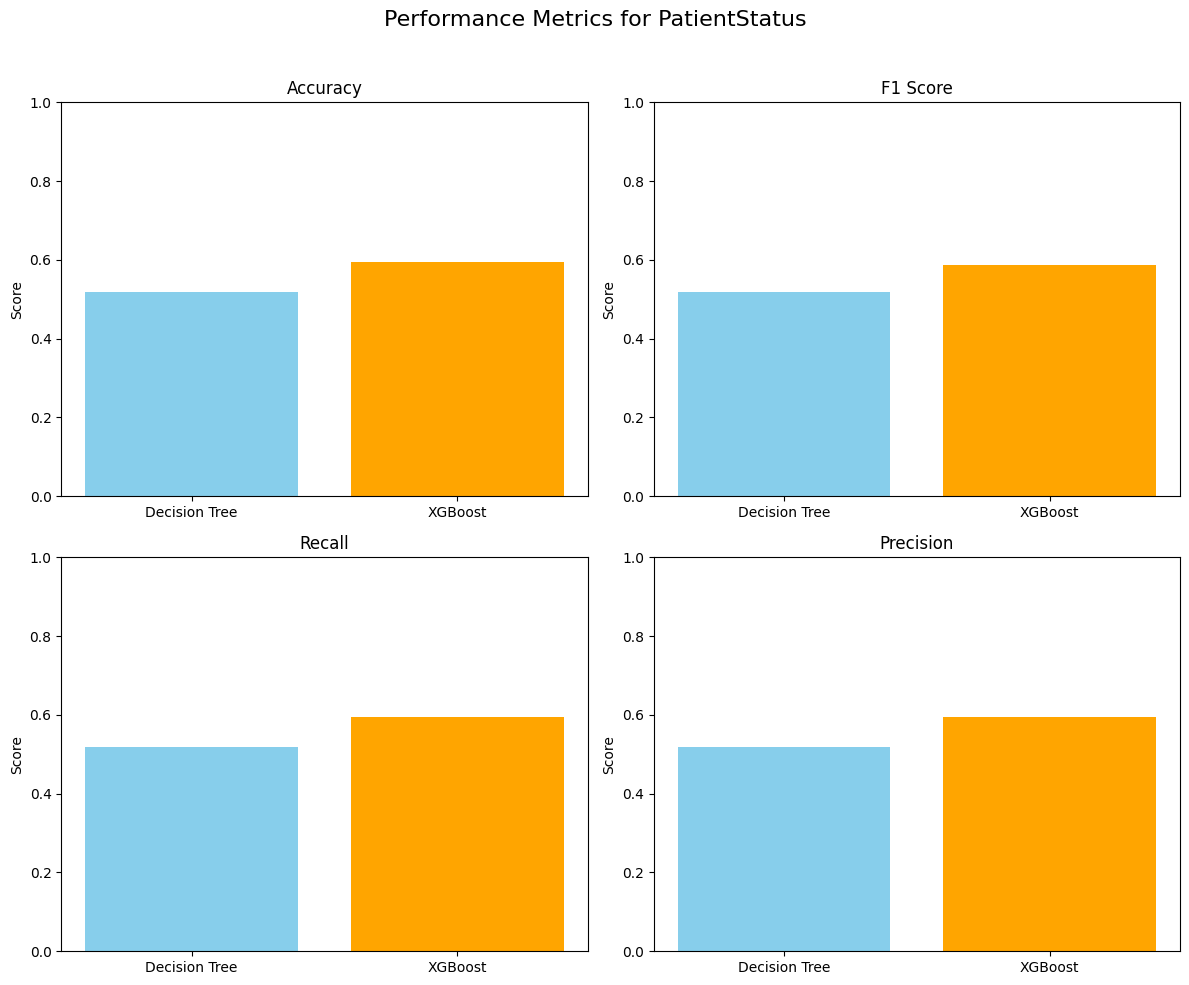

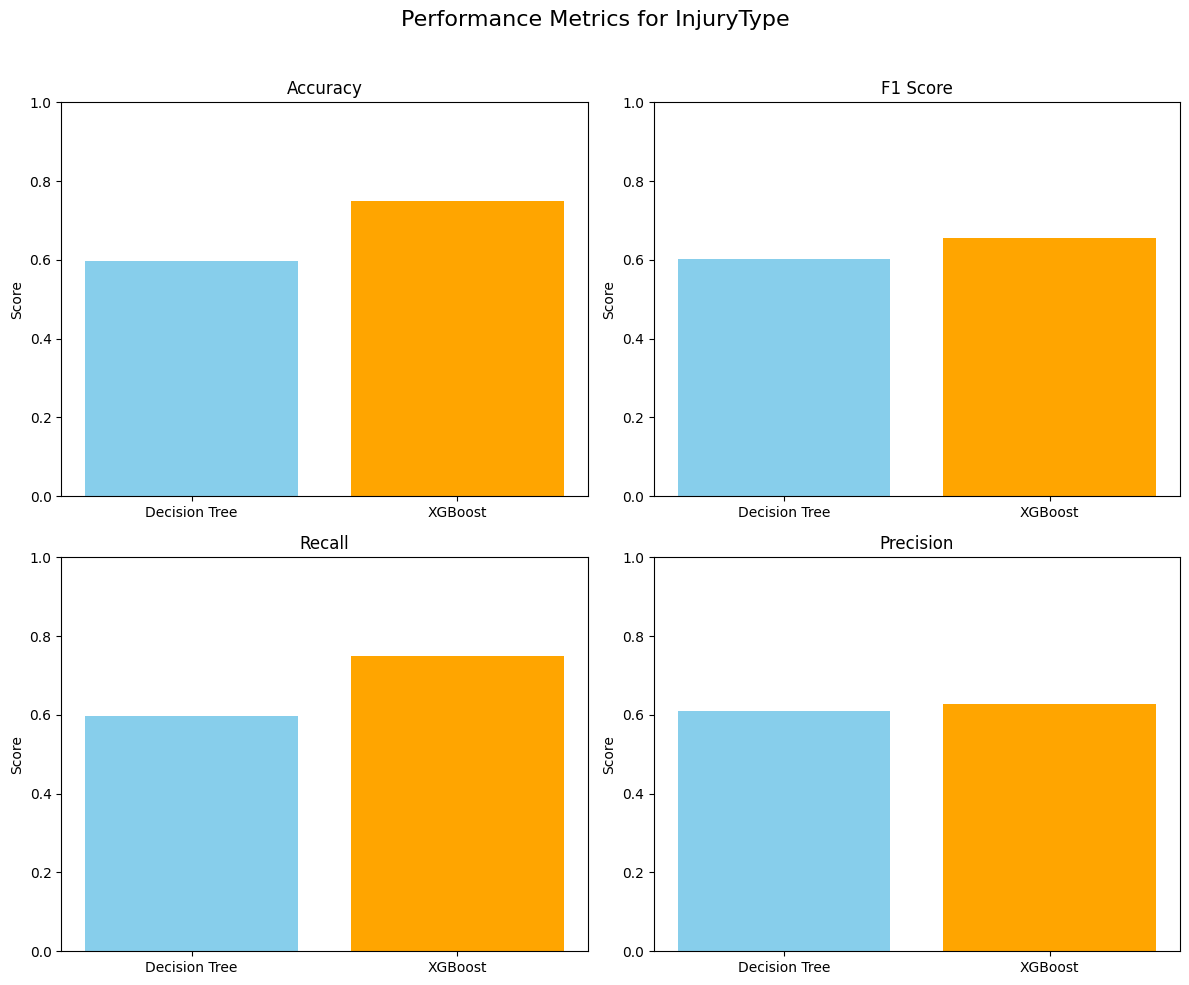

In [43]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_df, target):
    target_data = metrics_df[metrics_df['Target'] == target]

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Performance Metrics for {target}', fontsize=16)

    ax[0, 0].bar(target_data['Model'], target_data['Accuracy'], color=['skyblue', 'orange'])
    ax[0, 0].set_title('Accuracy')
    ax[0, 0].set_ylim(0, 1)

    ax[0, 1].bar(target_data['Model'], target_data['F1 Score'], color=['skyblue', 'orange'])
    ax[0, 1].set_title('F1 Score')
    ax[0, 1].set_ylim(0, 1)

    ax[1, 0].bar(target_data['Model'], target_data['Recall'], color=['skyblue', 'orange'])
    ax[1, 0].set_title('Recall')
    ax[1, 0].set_ylim(0, 1)

    ax[1, 1].bar(target_data['Model'], target_data['Precision'], color=['skyblue', 'orange'])
    ax[1, 1].set_title('Precision')
    ax[1, 1].set_ylim(0, 1)

    for axes in ax.flat:
        axes.set_ylabel('Score')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_metrics(metrics_df, 'PatientStatus')


plot_metrics(metrics_df, 'InjuryType')

In [56]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_model_status = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model_status.fit(X_train_status, y_train_status)

DecisionTreeClassifier(max_depth=3, random_state=42)

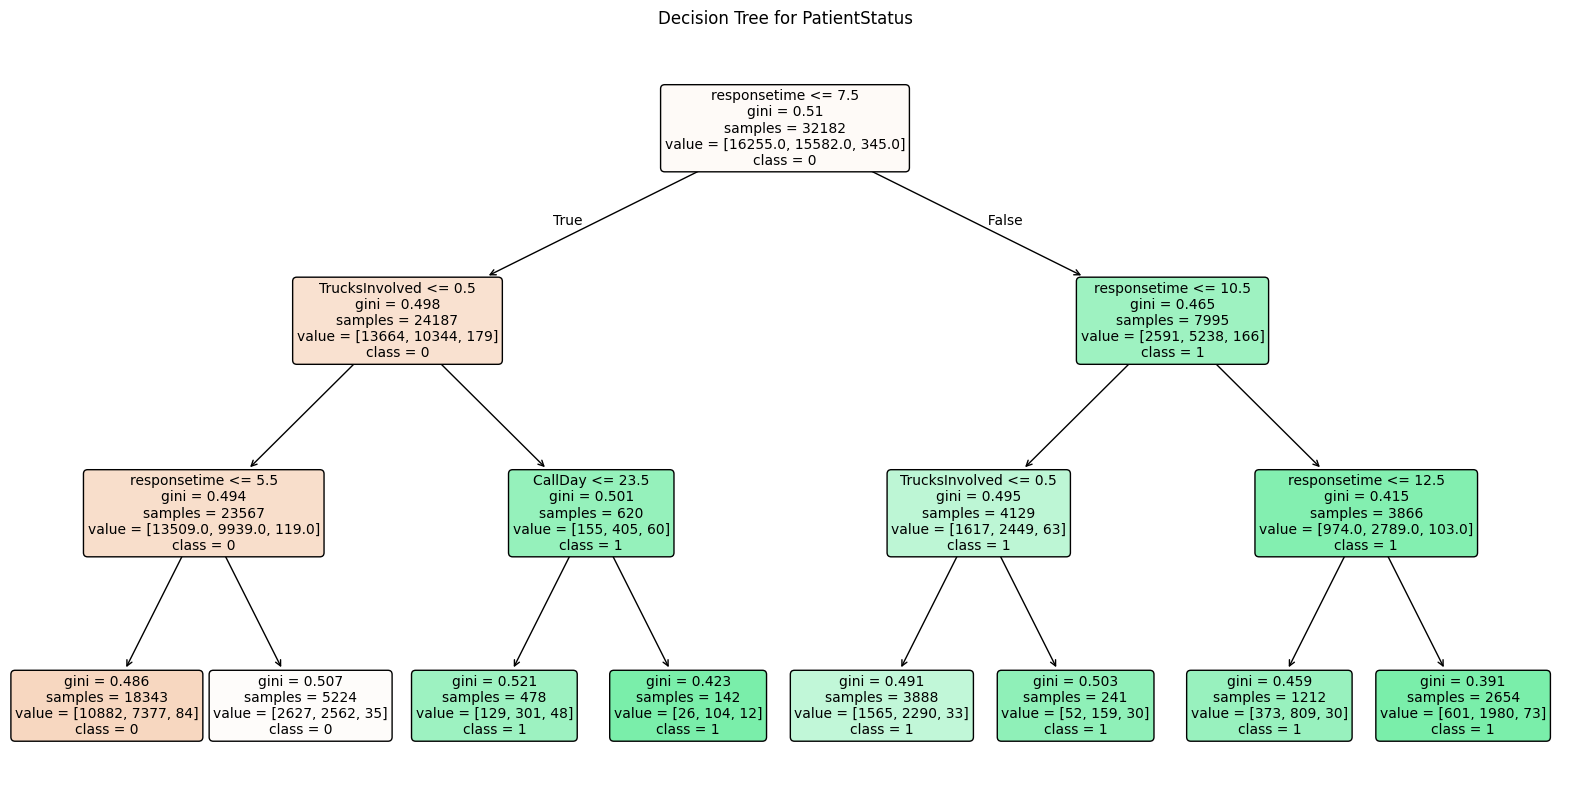

In [58]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

class_names_status = [str(cls) for cls in label_encoders['PatientStatus'].classes_]
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model_status,
    feature_names=X.columns,
    class_names=class_names_status,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for PatientStatus")
plt.show()

In [59]:
dt_model_injury = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model_injury.fit(X_train_injury, y_train_injury)

DecisionTreeClassifier(max_depth=3, random_state=42)

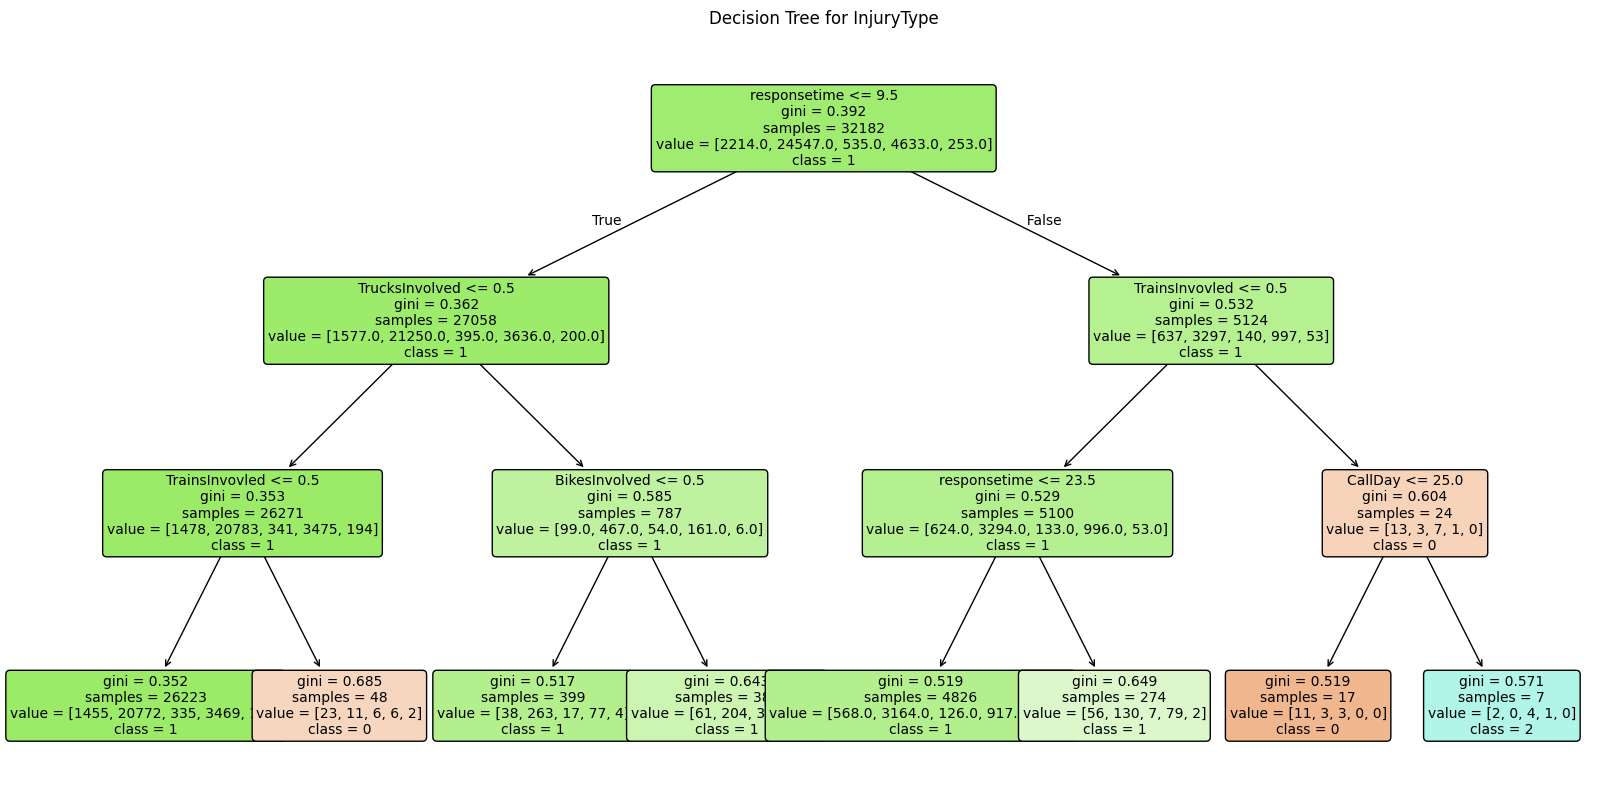

In [62]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model_injury,
    feature_names=X.columns,
    class_names=[str(cls) for cls in label_encoders['InjuryType'].classes_],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for InjuryType")
plt.show()